In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/__init__.py:42: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  warnings.warn("Starting from version 2.2.1, the library file in distribution wheels for macOS "


In [2]:
owid_data = pd.read_csv("./1_owid/owid-covid-data.csv")

In [3]:
owid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58154 entries, 0 to 58153
Data columns (total 52 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   iso_code                            57821 non-null  object 
 1   continent                           57472 non-null  object 
 2   location                            58154 non-null  object 
 3   date                                58154 non-null  object 
 4   total_cases                         57611 non-null  float64
 5   new_cases                           57604 non-null  float64
 6   new_cases_smoothed                  56649 non-null  float64
 7   total_deaths                        49288 non-null  float64
 8   new_deaths                          49287 non-null  float64
 9   new_deaths_smoothed                 56649 non-null  float64
 10  total_cases_per_million             57278 non-null  float64
 11  new_cases_per_million               57271

In [4]:
owid_data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'total_vaccinations_per_hundred', 'stringency_index', 'population',
       'population_density', 'median_age', 'aged_65_older', 'ag

In [5]:
data = owid_data.dropna(subset=["total_cases"])
data = data.loc[data['location'] == "World"]
# to ensure that we didn't use future data in prediction
data_sort = data.sort_values(by=["date"])
# drop columns that are all NaNs
data_sort = data_sort.dropna(axis=1, how='all')
data_sort.shape

(349, 32)

In [6]:
data_sort.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349 entries, 56966 to 57314
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   iso_code                         349 non-null    object 
 1   location                         349 non-null    object 
 2   date                             349 non-null    object 
 3   total_cases                      349 non-null    float64
 4   new_cases                        349 non-null    float64
 5   new_cases_smoothed               343 non-null    float64
 6   total_deaths                     349 non-null    float64
 7   new_deaths                       349 non-null    float64
 8   new_deaths_smoothed              343 non-null    float64
 9   total_cases_per_million          349 non-null    float64
 10  new_cases_per_million            349 non-null    float64
 11  new_cases_smoothed_per_million   343 non-null    float64
 12  total_deaths_per

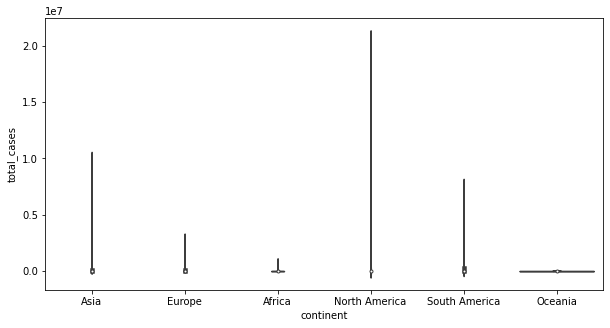

In [7]:
plt.figure(figsize=(10,5))
sns.violinplot(x = owid_data.continent, y=owid_data['total_cases'])
plt.xlabel('continent',fontsize=10)
plt.ylabel('total_cases',fontsize=10)
plt.show()

### ARIMA Model

In [8]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['total_cases'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

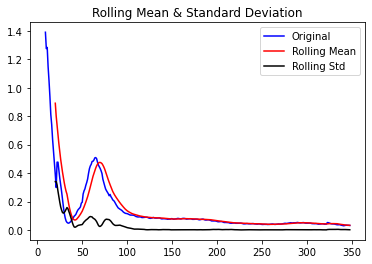

ADF Statistic: -8.233804682544637
p-value: 5.964430311381307e-13
Critical Values:
	1%: -3.4499043309021955
	5%: -2.870154885338925
	10%: -2.5713597190254385


In [9]:
df_log = pd.DataFrame(np.log(data_sort["total_cases"].values), columns=["total_cases"])
rolling_mean = df_log.rolling(window=10).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

> Use the original format

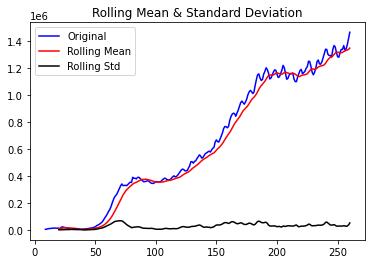

ADF Statistic: 0.16414721260278634
p-value: 0.9701774905666835
Critical Values:
	1%: -3.4584868856997004
	5%: -2.873918902362675
	10%: -2.573367247623359


In [10]:
train_size = int(data_sort.shape[0]*0.75)
df = data_sort[["total_cases"]].reset_index(drop=True).iloc[:train_size]
df_rolling_mean = df.rolling(window=10).mean()
df_minus_mean = df - df_rolling_mean
df_minus_mean.dropna(inplace=True)
get_stationarity(df_minus_mean)

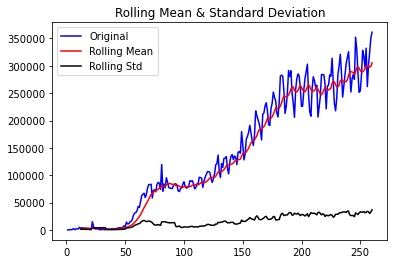

ADF Statistic: 0.43300548807781336
p-value: 0.9826881419811881
Critical Values:
	1%: -3.457437824930831
	5%: -2.873459364726563
	10%: -2.573122099570008


In [11]:
df_shift = df - df.shift()
df_shift.dropna(inplace=True)
get_stationarity(df_shift)

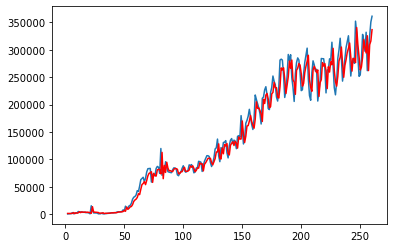

In [12]:
model = ARIMA(df, order=(2,1,2))
#model = ARIMA(df, order=(3,1,3))
results = model.fit(disp=-1)
plt.plot(df_shift[1:])
plt.plot(results.fittedvalues[1:], color='red')

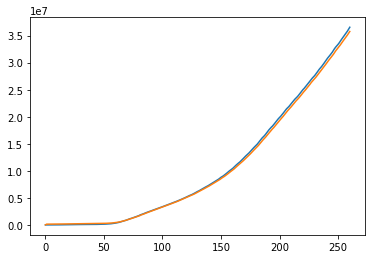

In [13]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA = pd.Series(df["total_cases"].iloc[0], index=df.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum, fill_value=0)
plt.plot(df)
plt.plot(predictions_ARIMA)

In [14]:
print(mean_squared_error(df, predictions_ARIMA, squared=False))

369699.6555169668


In [15]:
pred = results.predict(start=train_size, end = len(data_sort)-1)
predictions_ARIMA_diff = pd.Series(pred, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA = pd.Series(df["total_cases"].iloc[-1], index=predictions_ARIMA_diff_cumsum.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum, fill_value=0)

In [16]:
print(mean_squared_error(data_sort[["total_cases"]].reset_index(drop=True).iloc[train_size:], predictions_ARIMA, squared=False))

10910639.569159161


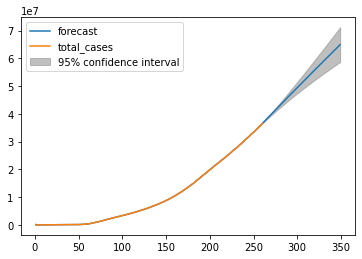

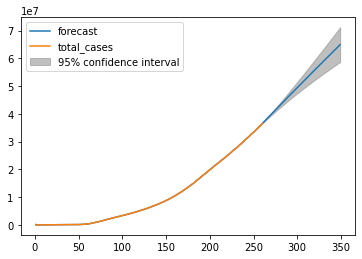

In [17]:
results.plot_predict(1, data_sort.shape[0])

### Models Using Multiple Columns - Regression and GBDT Model

> Notes: "iso_code": because it's same as location. Fillna: "total_vaccinations", "total_vaccinations_per_hundred" with 0.

In [18]:
data_model = data_sort.copy()
y_values = data_model['total_cases'].values[1:]
drop_cols = ['iso_code', 'location', 'date']

In [19]:
data_model[["total_vaccinations", "total_vaccinations_per_hundred", "reproduction_rate",
           "new_cases_smoothed", "new_cases_smoothed_per_million", "new_deaths_smoothed",
           "new_deaths_smoothed_per_million"]].describe()

,total_vaccinations,total_vaccinations_per_hundred,reproduction_rate,new_cases_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed,new_deaths_smoothed_per_million
count,2.200000e+01,22.000000,331.000000,343.000000,343.000000,343.000000,343.000000
mean,5.053475e+06,0.065909,1.220997,242256.267397,31.079222,5319.690977,0.682475
std,3.968496e+06,0.051238,0.446797,202880.501868,26.027693,3052.228626,0.391572
min,2.970000e+02,0.000000,0.650000,717.571000,0.092000,16.286000,0.002000
25%,1.842300e+06,0.025000,1.030000,79905.714000,10.251000,4302.357000,0.552000
50%,3.530897e+06,0.050000,1.080000,221238.143000,28.383000,5346.429000,0.686000
75%,6.301485e+06,0.077500,1.130000,331698.785500,42.553500,6314.428500,0.810000
max,1.299610e+07,0.170000,3.460000,646630.286000,82.957000,11670.429000,1.497000


In [20]:
data_model.fillna(0, inplace=True)
data_model.info()
x_values = data_model.drop(columns=drop_cols).iloc[:-1]
print(data_model.columns)
print(y_values.shape)
print(x_values.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349 entries, 56966 to 57314
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   iso_code                         349 non-null    object 
 1   location                         349 non-null    object 
 2   date                             349 non-null    object 
 3   total_cases                      349 non-null    float64
 4   new_cases                        349 non-null    float64
 5   new_cases_smoothed               349 non-null    float64
 6   total_deaths                     349 non-null    float64
 7   new_deaths                       349 non-null    float64
 8   new_deaths_smoothed              349 non-null    float64
 9   total_cases_per_million          349 non-null    float64
 10  new_cases_per_million            349 non-null    float64
 11  new_cases_smoothed_per_million   349 non-null    float64
 12  total_deaths_per

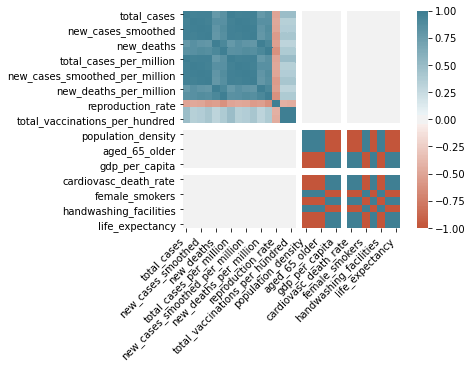

In [21]:
corr = data_model[[i for i in data_model.columns]].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
#ax.set_title('Correlation matrix',fontsize=15)
plt.savefig('corr_worldwide.png')

In [22]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
from gap_statistic import OptimalK

In [23]:
def plot_clusters(full_data, group_col):
    
    # seperate features only from cluster labels
    feature_columns = [colname for colname in list(full_data.columns) if 'Cluster' not in colname]
    features_only = full_data[feature_columns]

    # fit PCA to the whole data
    fitted_pca = PCA().fit(features_only)

    # take a sample of the whole data
    df_sample = features_only.sample(full_data.shape[0], random_state=109)
#     df_sample = full_data

    # apply the PCA transform on the sample
    pca_sample = pd.DataFrame(fitted_pca.transform(df_sample), columns = ["PCA{}".format(i) for i in range(len(df_sample.columns.values))])
    pca_sample.index = df_sample.index
    
    # re-include a cluster label for the pca data
    pca_sample[group_col] = full_data.loc[pca_sample.index, group_col]
    
    plt.figure(figsize=(11,8.5))
    marker_types = [".", "v", "1", "^", "s", "p", "P", "3", "H", "<", "|", "_", "x", "*","d","X"]
    marker_colors = np.concatenate([np.array(plt.cm.tab10.colors),np.array(plt.cm.Pastel1.colors)])
    
    for i, (cluster_id, cur_df) in enumerate(pca_sample.groupby([group_col])):

        pca1_scores = cur_df.iloc[:,0]
        pca2_scores = cur_df.iloc[:,1]
        plt.scatter(pca1_scores, pca2_scores, label=cluster_id, c=marker_colors[i].reshape(1,-1), marker=marker_types[i])

    plt.xlabel("PC1 ({}%)".format(np.round(100*fitted_pca.explained_variance_ratio_[0],1)))
    plt.ylabel("PC2 ({}%)".format(np.round(100*fitted_pca.explained_variance_ratio_[1],1)))
    plt.legend()
    plt.show()
    return pca_sample

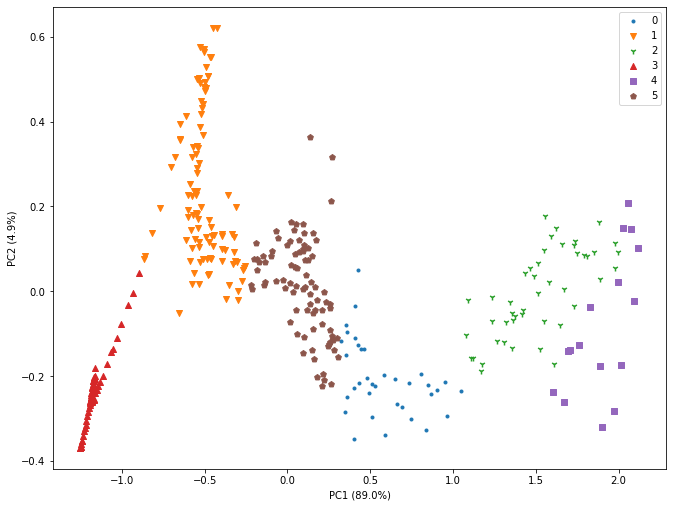

,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,...,PCA20,PCA21,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,Cluster6
328,1.882181,0.164271,-0.060869,0.197665,0.009445,0.096823,-0.107974,0.046382,-0.000477,-0.000132,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,-1.242835,-0.352997,-0.132822,0.335635,-0.187749,0.058950,0.018263,-0.001802,-0.000453,0.000044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
227,0.152450,-0.088416,-0.014052,-0.092812,0.000041,0.058102,0.031023,-0.003640,0.000024,-0.000243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
341,1.708981,-0.138015,0.556237,-0.022094,-0.040007,0.115833,-0.112656,0.021152,-0.002946,-0.000067,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
28,-1.164950,-0.206714,0.140811,-0.150551,0.159002,-0.079615,-0.089119,0.000940,0.000353,0.000204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,-0.610642,0.414107,0.027304,0.065422,-0.064589,-0.052743,-0.043259,-0.003194,0.000286,0.000197,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
141,-0.448351,0.105732,0.019329,-0.030454,0.040932,0.025397,0.031941,0.007336,-0.000241,-0.000050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
347,1.902092,-0.318896,1.188317,0.227362,-0.166105,-0.116564,0.142923,0.042666,0.012724,-0.000038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
245,0.250234,-0.123316,-0.016776,-0.073929,0.031521,0.121979,-0.006849,0.023884,-0.000029,-0.000158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [24]:
scaler = MinMaxScaler()
data_mod = data_model.drop(columns=drop_cols)
scaler.fit(data_mod)
df_process = scaler.transform(data_mod)
df_process = pd.DataFrame(df_process, columns = data_mod.columns)

km6 = KMeans(n_clusters=6, n_init=46, random_state=109).fit(df_process)
df_process['Cluster6'] = km6.labels_
plot_clusters(df_process, 'Cluster6')

In [25]:
train_size = int(x_values.shape[0]*0.75)
x_train = x_values.iloc[:train_size]
x_test = x_values.iloc[train_size:]
y_train = y_values[:train_size]
y_test = y_values[train_size:]

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
result_df = pd.DataFrame()
lr = LinearRegression().fit(x_train, y_train)

lr_train_acc = mean_squared_error(y_train, lr.predict(x_train), squared=False)
lr_test_acc = mean_squared_error(y_test, lr.predict(x_test), squared=False)

print('Baseline regression: RMSE on train set is ', str(round(lr_train_acc,4)))
print('Baseline regression: RMSE on test set is ', str(round(lr_test_acc,4)))

Baseline regression: RMSE on train set is  16407.302
Baseline regression: RMSE on test set is  110225.1956


In [27]:
from sklearn.metrics import r2_score
print(r2_score(y_train, lr.predict(x_train)))
print(r2_score(y_test, lr.predict(x_test)))

0.9999978263842648
0.9999441799436273


In [28]:
lr.coef_

array([ 3.98688442e+02,  6.05047228e+02,  1.02648039e+02, -3.86633137e+01,
       -4.20470313e+02, -3.54988017e+02, -3.09990575e+06, -4.71370705e+06,
       -7.95203816e+05,  3.01669424e+05,  3.32110434e+06,  2.72238069e+06,
        2.42852756e+03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.46898363e-08,  0.00000000e+00,  0.00000000e+00, -1.83622954e-09,
        3.76059809e-06,  0.00000000e+00, -5.87593452e-08,  0.00000000e+00,
        1.83622954e-09, -1.46898363e-08,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

In [29]:
sub_col = ["total_cases", 'reproduction_rate',
       'total_vaccinations', 'total_vaccinations_per_hundred', 'population',
       'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
       'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy']

In [30]:
from sklearn.preprocessing import PolynomialFeatures

inters= PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)
x_interaction_train = inters.fit_transform(x_train)
x_interaction_train_df = pd.DataFrame(x_interaction_train,columns = inters.get_feature_names(x_train.columns))

x_interaction_test = inters.fit_transform(x_test.copy())
x_interaction_test_df = pd.DataFrame(x_interaction_test,columns= inters.get_feature_names(x_test.columns))

In [31]:
lr_inter = LinearRegression().fit(x_interaction_train_df,y_train)

inter_train_acc = mean_squared_error(y_train, lr_inter.predict(x_interaction_train_df), squared=False)
inter_test_acc = mean_squared_error(y_test, lr_inter.predict(x_interaction_test_df), squared=False)

print('Linear regression with interaction term: RMSE on train set is ', str(round(inter_train_acc,4)))
print('Linear regression with interaction term: RMSE on test set is ', str(round(inter_test_acc,4)))

Linear regression with interaction term: RMSE on train set is  17569.2143
Linear regression with interaction term: RMSE on test set is  1355550.1642


> Simple Decision Tree with max depth = 3

In [32]:
from sklearn.tree import DecisionTreeClassifier
tree0 = DecisionTreeClassifier(max_depth=3)
tree0.fit(x_train, y_train)
y_pred_test = tree0.predict(x_test)
y_pred_train = tree0.predict(x_train)
acc_test_tree = mean_squared_error(y_test, y_pred_test, squared=False)

acc_train_tree = mean_squared_error(y_train,y_pred_train, squared=False)

print("Decision Tree RMSE in train set is: " + str(round(acc_train_tree, 4)))
print("Decision Tree RMSE in test set is: " + str(round(acc_test_tree, 4)))

Decision Tree RMSE in train set is: 15412684.5105
Decision Tree RMSE in test set is: 61439291.0636


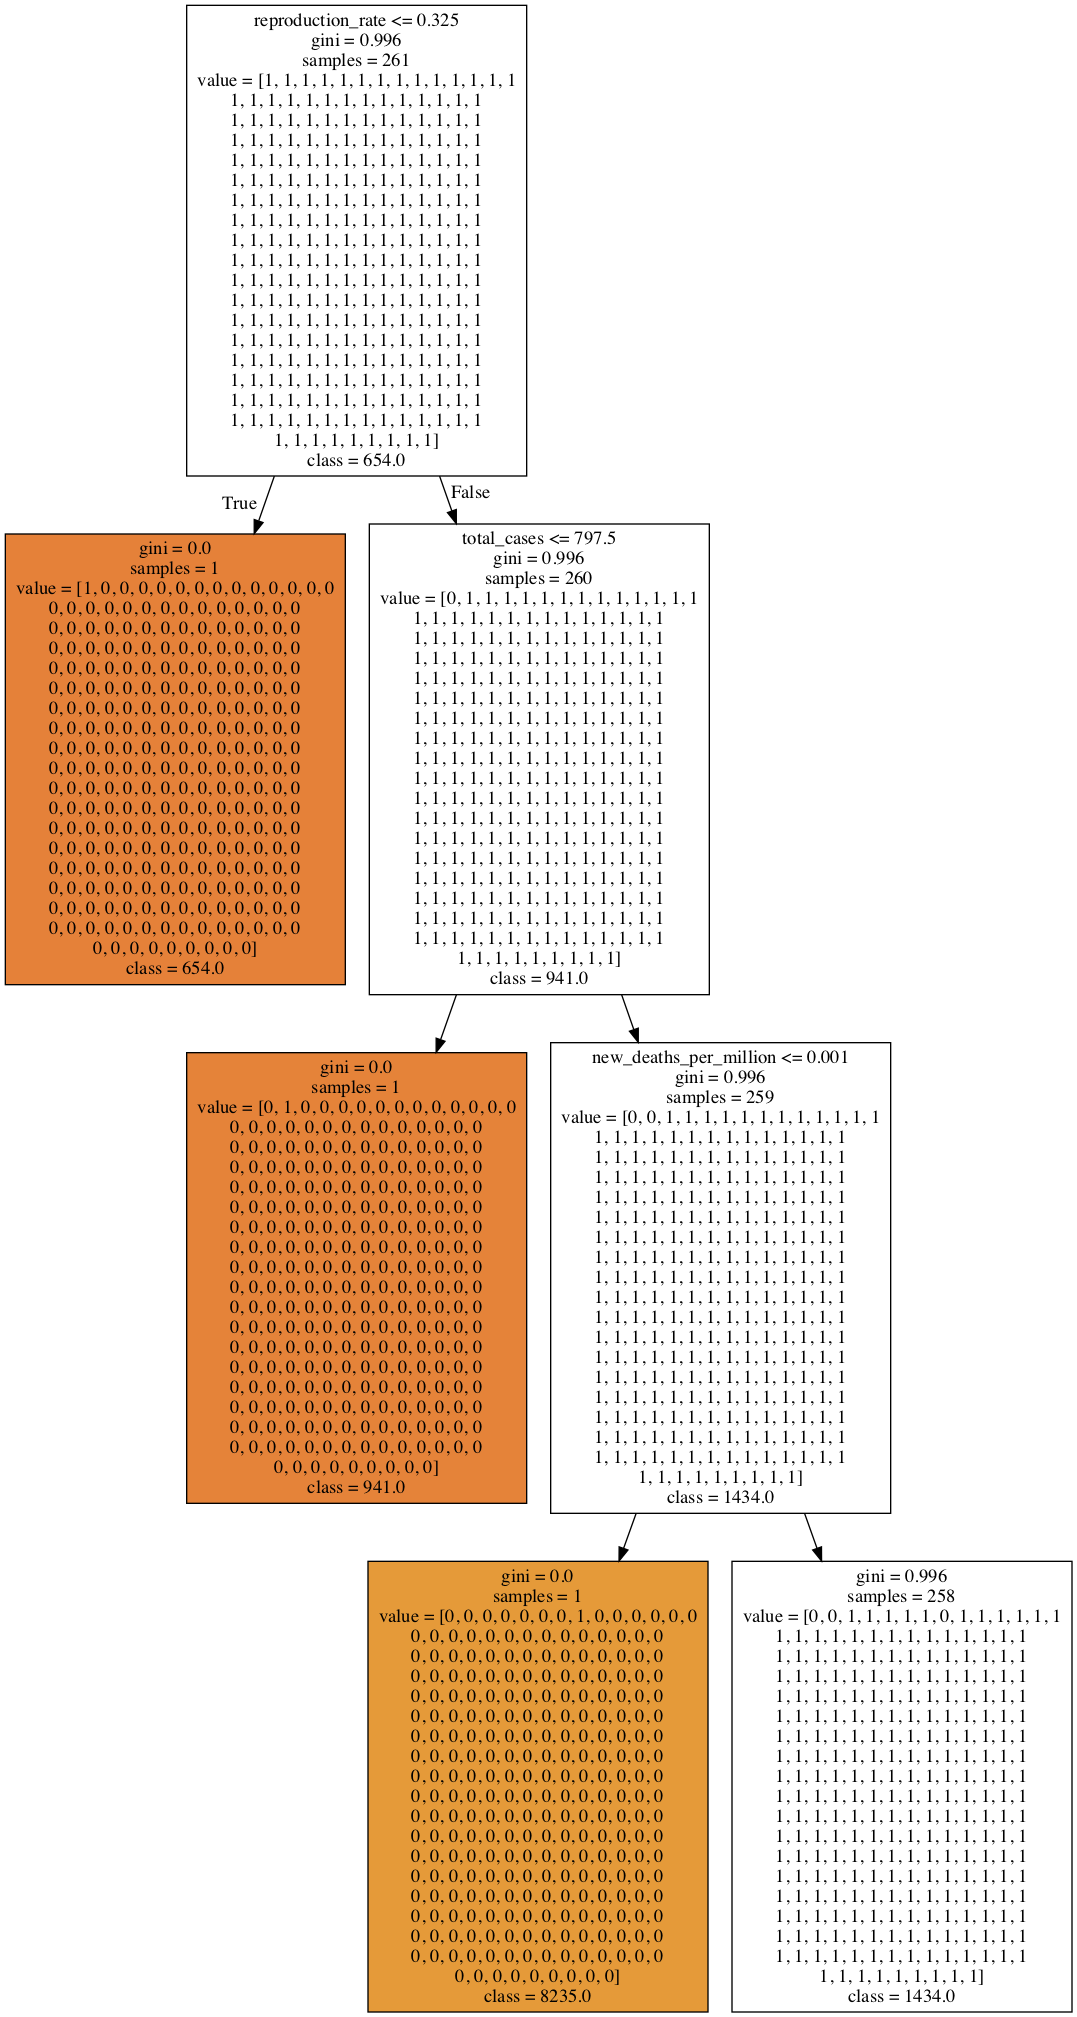

In [33]:
import pydotplus
import sklearn.tree as tree
from IPython.display import Image

dt_feature_names = list(x_train.columns)
dt_target_names = [str(s) for s in y_train]
tree.export_graphviz(tree0, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

In [34]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

x_train_gbm, x_val_gbm, y_train_gbm, y_val_gbm = train_test_split(x_train, y_train, train_size=0.85, random_state=1)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'max_depth': 100,
    'seed': 1
}
lgb_train = lgb.Dataset(x_train_gbm, y_train_gbm, feature_name=list(x_train.columns))
lgb_eval = lgb.Dataset(x_val_gbm, y_val_gbm, feature_name=list(x_train.columns))
model2 = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=[lgb_train, lgb_eval], 
                valid_names=["train", "eval"], early_stopping_rounds=1500, verbose_eval=False)
y_pred_train = model2.predict(x_train, num_iteration=model2.best_iteration)
acc_lgb_train = mean_squared_error(y_train, y_pred_train, squared=False)

y_pred_test = model2.predict(x_test, num_iteration=model2.best_iteration)
acc_lgb_test = mean_squared_error(y_test, y_pred_test, squared=False)

print("RMSE in train set is: " + str(round(acc_lgb_train, 4)))
print("RMSE in test set is: " + str(round(acc_lgb_test, 4)))

RMSE in train set is: 344163.6744
RMSE in test set is: 28763945.5363


In [35]:
import shap
explainer = shap.TreeExplainer(model2)
shap_values = explainer.shap_values(x_train)

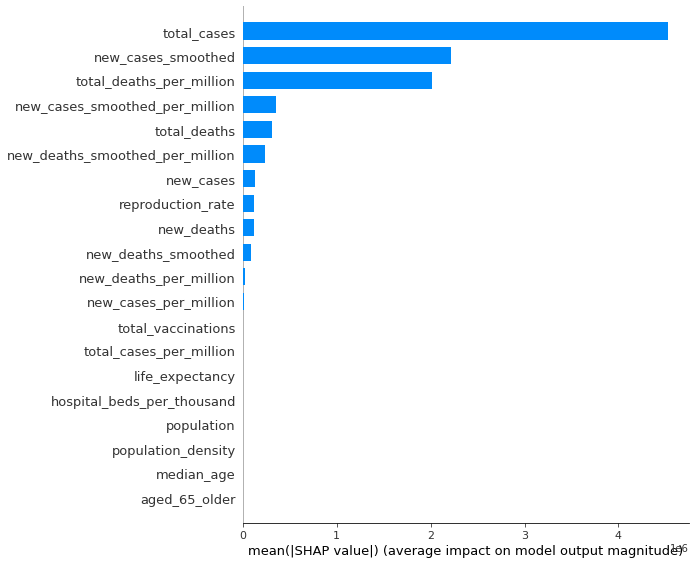

In [36]:
shap.summary_plot(shap_values, x_train, plot_type="bar", feature_names=x_train.columns)

In [37]:
shap_interaction_values = shap.TreeExplainer(model2).shap_interaction_values(x_train)

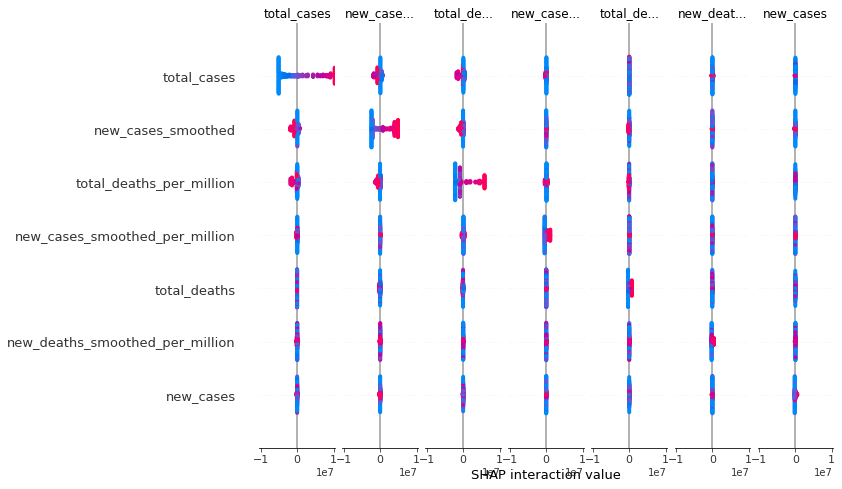

In [38]:
shap.summary_plot(shap_interaction_values,x_train,feature_names=x_train.columns)

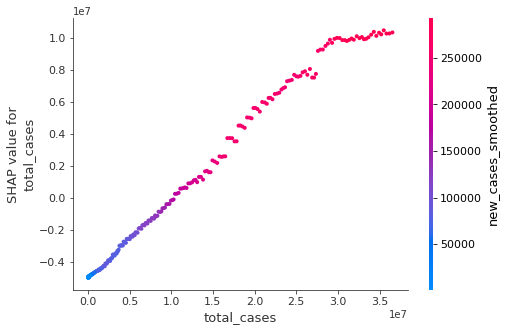

In [39]:
shap.dependence_plot("total_cases", shap_values, x_train, interaction_index='new_cases_smoothed',feature_names=x_train.columns)

In [40]:
variable_drop = []
accs_train_gbm = []
accs_test_gbm = []
accs_train_logis = []
accs_test_logis = []
accs_train_logis_l2 = []
accs_test_logis_l2 = []

for i in range(29):
    print(i)
    df_temp_train = x_train.copy()
    df_temp_test = x_test.copy()
    if i > 0:
        x_train_feature = df_temp_train.drop(variable_drop, axis=1)
        x_test_feature = df_temp_test.drop(variable_drop, axis=1)
    else:
        x_train_feature = df_temp_train.copy()
        x_test_feature = df_temp_test.copy()
    x_train_gbm, x_val_gbm, y_train_gbm, y_val_gbm = train_test_split(x_train_feature, y_train, train_size=0.85, random_state=1)
    params = {
      'boosting_type': 'gbdt',
      'objective': 'regression',
      'learning_rate': 0.01,
      'feature_fraction': 0.9,
      'bagging_fraction': 0.9,
      'bagging_freq': 5,
      'max_depth': 100,
      'seed': 1
    }
    lgb_train = lgb.Dataset(x_train_gbm, y_train_gbm, feature_name=list(x_train_feature.columns))
    lgb_eval = lgb.Dataset(x_val_gbm, y_val_gbm, feature_name=list(x_train_feature.columns))
    model_fea = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=[lgb_train, lgb_eval], 
                  valid_names=["train", "eval"], early_stopping_rounds=1500, verbose_eval=False)
    y_pred_lgb_train = model_fea.predict(x_train_feature, num_iteration=model_fea.best_iteration)
    acc_lgb_train = mean_squared_error(y_train, y_pred_lgb_train, squared=False)

    y_pred_lgb_test = model_fea.predict(x_test_feature, num_iteration=model_fea.best_iteration)
    acc_lgb_test = mean_squared_error(y_test, y_pred_lgb_test,squared=False)
    accs_train_gbm.append(acc_lgb_train)
    accs_test_gbm.append(acc_lgb_test)
    lr = LinearRegression().fit(x_train_feature, y_train)
    accs_train_logis_l2.append(mean_squared_error(y_train, lr.predict(x_train_feature), squared=False))
    accs_test_logis_l2.append(mean_squared_error(y_test, lr.predict(x_test_feature), squared=False))

    # drop
    explainer = shap.TreeExplainer(model_fea)
    shap_values = explainer.shap_values(x_train_feature)
    mean_shap_feature_values = pd.DataFrame(shap_values, 
                                          columns=x_train_feature.columns).abs().mean(axis=0).sort_values(ascending=False)
    variable_drop.append(list(mean_shap_feature_values.index)[-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


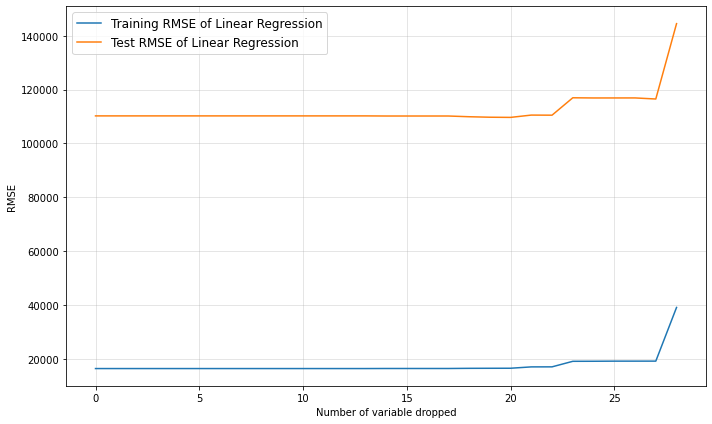

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
#ax.plot(range(len(accs_train_gbm)), accs_train_gbm, label="Training RMSE of LightGBM")
# ax.plot(range(len(accs_train_gbm)), accs_test_gbm, label="Test RMSE of LightGBM")
ax.plot(range(len(accs_train_gbm)), accs_train_logis_l2, label="Training RMSE of Linear Regression")
ax.plot(range(len(accs_train_gbm)), accs_test_logis_l2, label="Test RMSE of Linear Regression")
plt.legend(fontsize=12)
plt.xlabel("Number of variable dropped")
plt.ylabel("RMSE")
plt.grid(':', alpha=0.4)
plt.tight_layout()
plt.show()

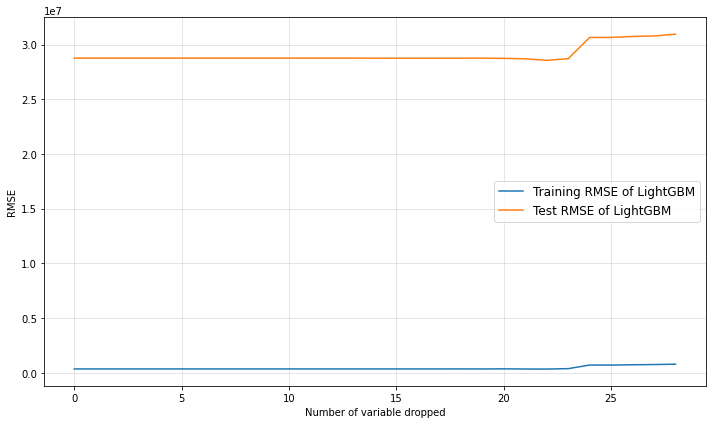

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(accs_train_gbm)), accs_train_gbm, label="Training RMSE of LightGBM")
ax.plot(range(len(accs_train_gbm)), accs_test_gbm, label="Test RMSE of LightGBM")
# ax.plot(range(len(accs_train_gbm)), accs_train_logis_l2, label="Training RMSE of Linear Regression")
# ax.plot(range(len(accs_train_gbm)), accs_test_logis_l2, label="Test RMSE of Linear Regression")
plt.legend(fontsize=12)
plt.xlabel("Number of variable dropped")
plt.ylabel("RMSE")
plt.grid(':', alpha=0.4)
plt.tight_layout()
plt.show()

In [43]:
print(variable_drop)
print(len(variable_drop))

['total_vaccinations_per_hundred', 'total_vaccinations', 'population', 'life_expectancy', 'hospital_beds_per_thousand', 'handwashing_facilities', 'male_smokers', 'female_smokers', 'diabetes_prevalence', 'cardiovasc_death_rate', 'extreme_poverty', 'gdp_per_capita', 'aged_70_older', 'total_cases_per_million', 'population_density', 'median_age', 'aged_65_older', 'new_cases_per_million', 'new_deaths_per_million', 'new_deaths_smoothed', 'new_deaths', 'reproduction_rate', 'new_cases', 'new_deaths_smoothed_per_million', 'total_deaths', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_cases_smoothed', 'total_cases']
29


In [44]:
print(accs_train_gbm)

[344163.6743521685, 344163.6743521685, 344163.6743521685, 344163.6743521685, 344163.6743521685, 344163.6743521685, 344163.6743521685, 344163.6743521685, 344163.6743521685, 344163.6743521685, 344163.6743521685, 344163.6743521685, 344163.6743521685, 344163.6743521685, 343407.7345512519, 343407.7345512519, 343407.7345512519, 343407.7345512519, 345895.5430117117, 340375.52932957624, 354305.45374076004, 337263.78651103616, 333908.6277648657, 371368.5059790471, 699291.6775230605, 699291.6775230605, 725379.2596963025, 746017.9634772355, 779784.600127768]


In [45]:
val_list = ['new_deaths_smoothed_per_million', 'total_deaths', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_cases_smoothed', 'total_cases']

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

x_train_gbm, x_val_gbm, y_train_gbm, y_val_gbm = train_test_split(x_train[val_list], y_train, train_size=0.85, random_state=1)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'max_depth': 100,
    'seed': 1
}
lgb_train = lgb.Dataset(x_train_gbm, y_train_gbm, feature_name=list(x_train[val_list].columns))
lgb_eval = lgb.Dataset(x_val_gbm, y_val_gbm, feature_name=list(x_train[val_list].columns))
model2 = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=[lgb_train, lgb_eval], 
                valid_names=["train", "eval"], early_stopping_rounds=1500, verbose_eval=False)
y_pred_train = model2.predict(x_train[val_list], num_iteration=model2.best_iteration)
acc_lgb_train = mean_squared_error(y_train, y_pred_train, squared=False)

y_pred_test = model2.predict(x_test[val_list], num_iteration=model2.best_iteration)
acc_lgb_test = mean_squared_error(y_test, y_pred_test, squared=False)

print("RMSE in train set is: " + str(round(acc_lgb_train, 4)))
print("RMSE in test set is: " + str(round(acc_lgb_test, 4)))

RMSE in train set is: 369829.4827
RMSE in test set is: 28698053.4994


In [46]:
val_list = ['new_cases','new_deaths_smoothed_per_million', 'total_deaths', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_cases_smoothed', 'total_cases']
lr = LinearRegression().fit(x_train[val_list], y_train)

lr_train_acc = mean_squared_error(y_train, lr.predict(x_train[val_list]), squared=False)
lr_test_acc = mean_squared_error(y_test, lr.predict(x_test[val_list]), squared=False)

print('Baseline regression: RMSE on train set is ', str(round(lr_train_acc,4)))
print('Baseline regression: RMSE on test set is ', str(round(lr_test_acc,4)))

Baseline regression: RMSE on train set is  17040.1007
Baseline regression: RMSE on test set is  110489.1903


In [47]:
from sklearn.linear_model import Lasso
lr = Lasso().fit(x_train[val_list], y_train)

lr_train_acc = mean_squared_error(y_train, lr.predict(x_train[val_list]), squared=False)
lr_test_acc = mean_squared_error(y_test, lr.predict(x_test[val_list]), squared=False)

print('Baseline regression: RMSE on train set is ', str(round(lr_train_acc,4)))
print('Baseline regression: RMSE on test set is ', str(round(lr_test_acc,4)))

Baseline regression: RMSE on train set is  17045.0874
Baseline regression: RMSE on test set is  110480.7472


In [48]:
from sklearn.linear_model import Ridge
lr = Ridge().fit(x_train[val_list], y_train)

lr_train_acc = mean_squared_error(y_train, lr.predict(x_train[val_list]), squared=False)
lr_test_acc = mean_squared_error(y_test, lr.predict(x_test[val_list]), squared=False)

print('Baseline regression: RMSE on train set is ', str(round(lr_train_acc,4)))
print('Baseline regression: RMSE on test set is ', str(round(lr_test_acc,4)))

Baseline regression: RMSE on train set is  17045.1135
Baseline regression: RMSE on test set is  110432.6052


Ill-conditioned matrix (rcond=3.00426e-17): result may not be accurate.


> ML performs not very well; small data points; maybe groupedby continent would be better

In [49]:
owid_data.groupby(by=["continent"]).count()

,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
continent,,,,,,,,,,,,,,,,,,,,,
Africa,15909,15909,15909,15822,15822,15552,13936,13936,15552,15822,...,15614,12094,15909,15909,10631,10631,12952,11837,15909,15614
Asia,14673,14673,14673,14546,14540,14311,11803,11802,14311,14546,...,14029,8820,14602,14029,12157,12157,7756,13638,14673,14318
Europe,14651,14651,14651,14487,14487,14257,13254,13254,14257,14487,...,13419,9526,13118,14049,12804,12804,923,13740,14354,13425
North America,7008,7008,7008,6923,6922,6807,5238,5238,6807,6923,...,6709,3479,6722,7008,4052,3752,3966,7008,7008,7008
Oceania,1547,1547,1547,1498,1498,1458,910,910,1458,1498,...,1547,827,1547,1547,1393,1393,210,1152,1547,1547
South America,3684,3684,3684,3653,3653,3593,3478,3478,3593,3653,...,3684,2791,3684,3684,2788,2483,1815,3684,3684,3684
